In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, Reshape,GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()
from keras.utils import np_utils
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import random
# from scipy.signal import find_peaks

In [2]:
root_dir = "../DataBarCrawl/"
list_dir =sorted(os.listdir(root_dir))
list_dir

['README.txt',
 'all_accelerometer_data_pids_13.csv',
 'clean_tac',
 'phone_types.csv',
 'pids.txt',
 'raw_tac',
 'traindata']

In [3]:
os.chdir(root_dir)
dataFile = list_dir[1]
data = pd.read_csv(dataFile)
# data.head()
data = data[data['time'] != 0]
data = data.sort_values(by=['pid','time'],ignore_index=True)
os.chdir(root_dir)
tac_dir = "/clean_tac"
os.chdir(root_dir + tac_dir)
tacLsdir = os.listdir()
tacs = {}
for pid_csv in tacLsdir:
    pid = pid_csv[:6]
    # print(pid)
    tacs[pid] = pd.read_csv(pid_csv)
# tacs
pid_acc_data={}
pids = list(tacs.keys())
for pid in pids:
    pid_acc_data[pid] = data[data['pid']==pid]
all_data = []
for pid in pids:
    df1 = tacs[pid]
#     Shift TAC reading by 45 minutes before merging with accelerometer data
    # df1['shift_timestamp'] = df1['timestamp'] - (45*60)
    df2 = data[data['pid']==pid]
#     Change timestamp in accelerometer data from milisec to sec
    df2['timestamp'] = df2['time']//1000 
#     Merge the TAC reading and accelerometer data on timestamp
    tmp = df1.merge(df2, on='timestamp')
    tmp['label'] = np.where(tmp['TAC_Reading']<0.08, 0, 1)

    all_data.append(tmp)
large_df = pd.concat(all_data)

<ipython-input-3-f3b6579ea9b6>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['timestamp'] = df2['time']//1000


In [38]:
participants = list(pids)
print(participants)
random.seed(100)
def Diff(li1, li2):
  return list(set(li1) - set(li2)) + list(set(li2) - set(li1))
p_tr_index = random.sample(range(0, 13), 9)  # 70%13 = 9.1~9
p_te_index = Diff(list(range(0, 13)),p_tr_index)  #

['BK7610', 'BU4707', 'CC6740', 'DC6359', 'DK3500', 'HV0618', 'JB3156', 'JR8022', 'MC7070', 'MJ8002', 'PC6771', 'SA0297', 'SF3079']


In [39]:
assert len(p_tr_index) + len(p_te_index) == 13

In [40]:
p_te=[]
p_tr = []
for index in p_tr_index:
    p_tr.append(participants[index])
for index in p_te_index:
    p_te.append(participants[index])

In [41]:
p_tr

['CC6740',
 'JR8022',
 'SA0297',
 'SF3079',
 'JB3156',
 'HV0618',
 'DC6359',
 'DK3500',
 'BK7610']

In [42]:
p_te

['MC7070', 'BU4707', 'PC6771', 'MJ8002']

In [43]:
df_train = pd.DataFrame()
for pid in p_tr:
    tmp = large_df[large_df["pid"]==pid]
    df_train = df_train.append(tmp)

In [44]:
df_test = pd.DataFrame()
for pid in p_te:
    tmp = large_df[large_df["pid"]==pid]
    df_test = df_test.append(tmp)

In [45]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

In [46]:
def create_segments_and_labels(df, time_steps, step):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x'].values[i: i + time_steps]
        ys = df['y'].values[i: i + time_steps]
        zs = df['z'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label =(df_train['label'][i: i + time_steps]).max()
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


In [47]:
df_train['x'] = feature_normalize(df_train['x'])
df_train['y'] = feature_normalize(df_train['y'])
df_train['z'] = feature_normalize(df_train['z'])
df_test['x'] = feature_normalize(df_test['x'])
df_test['y'] = feature_normalize(df_test['y'])
df_test['z'] = feature_normalize(df_test['z'])

window size = 5 seconds
samples = 40*5 = 200

In [48]:
TIME_PERIODS = 200
x_train, y_train = create_segments_and_labels(df_train,TIME_PERIODS,25)

In [49]:
print('x_train shape: ', x_train.shape)

x_train shape:  (178, 200, 3)


In [50]:
print(x_train.shape[0], 'training samples')

178 training samples


In [51]:
print('y_train shape: ', y_train.shape)

y_train shape:  (178,)


In [52]:
le = LabelEncoder()
LABELS= le.fit(y_train)

In [53]:
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

[0, 1]


In [54]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)

In [55]:
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (178, 600)
input_shape: 600


In [56]:
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

In [57]:
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)

New y_train shape:  (178, 2)


In [58]:
def modelCNN(TIME_PERIODS,input_shape):
    model = Sequential()
    model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
    model.add(Conv1D(filters=64, kernel_size=10, activation='relu',input_shape=(TIME_PERIODS,num_sensors)))
    model.add(Conv1D(filters=64,kernel_size=10,activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Conv1D(128, 10, activation='relu'))
    # model.add(Conv1D(160, 10, activation='relu'))
    # model.add(GlobalAveragePooling1D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [59]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

In [60]:
verbose, epochs, batch_size = 0, 50, 32
# fit network
model = modelCNN(TIME_PERIODS,input_shape)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.3)
	# evaluate model
# _, accuracy = model.evaluate(X_test, testy, batch_size=batch_size, verbose=0)
# print(accuracy)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 200, 3)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 191, 64)           1984      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 182, 64)           41024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 182, 64)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 60, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 51, 128)           82048     
_________________________________________________________________
flatten_2 (Flatten)          (None, 6528)             

In [61]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

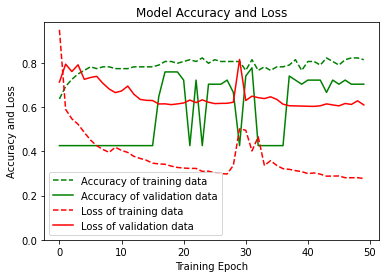

In [62]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


Accuracy on test data: 0.72

Loss on test data: 2.42

--- Confusion matrix for test data ---



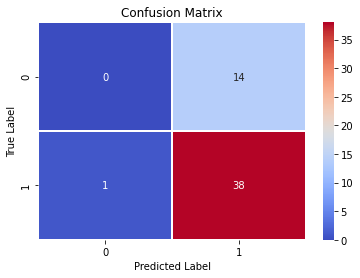


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.73      0.97      0.84        39

    accuracy                           0.72        53
   macro avg       0.37      0.49      0.42        53
weighted avg       0.54      0.72      0.61        53



In [63]:
x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            25)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model.evaluate(x_test, y_test, verbose=verbose)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

# %%

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

# %%

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

window size 10 seconds 

In [64]:
TIME_PERIODS = 400

In [65]:
x_train, y_train = create_segments_and_labels(df_train,TIME_PERIODS,25)

In [66]:
le = LabelEncoder()
LABELS= le.fit(y_train)
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)

[0, 1]
New y_train shape:  (170, 2)


In [67]:
verbose, epochs, batch_size = 0, 60, 32
# fit network
model = modelCNN(TIME_PERIODS,input_shape)
history2 = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.3)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 400, 3)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 391, 64)           1984      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 382, 64)           41024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 382, 64)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 127, 64)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 118, 128)          82048     
_________________________________________________________________
flatten_3 (Flatten)          (None, 15104)            

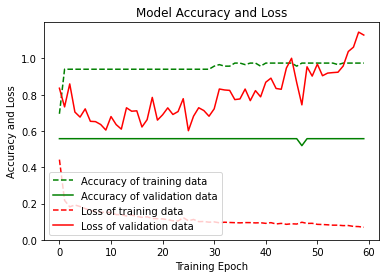

In [68]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history2.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history2.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history2.history['loss'], "r--", label="Loss of training data")
plt.plot(history2.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


Accuracy on test data: 0.93

Loss on test data: 26.41

--- Confusion matrix for test data ---



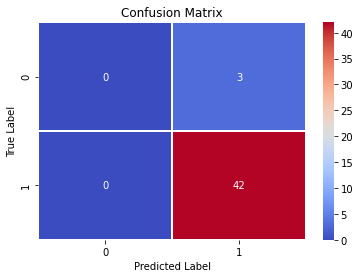


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.93      1.00      0.97        42

    accuracy                           0.93        45
   macro avg       0.47      0.50      0.48        45
weighted avg       0.87      0.93      0.90        45



C:\Users\shubh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            25)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model.evaluate(x_test, y_test, verbose=verbose)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

# %%

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

# %%

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

window size 2 seconds
40*2 = 80

In [70]:
TIME_PERIODS = 80

In [71]:
x_train, y_train = create_segments_and_labels(df_train,TIME_PERIODS,25)
le = LabelEncoder()
LABELS= le.fit(y_train)
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)
verbose, epochs, batch_size = 0, 60, 32
# fit network
model = modelCNN(TIME_PERIODS,input_shape)
history3 = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)

[0, 1]
New y_train shape:  (183, 2)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 71, 64)            1984      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 62, 64)            41024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 64)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 11, 128)           82048     
_________________________________________________________________
flatten_4 (Flatten

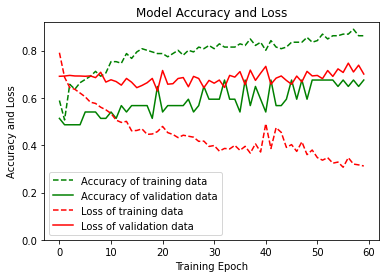

In [73]:
plt.figure(figsize=(6, 4))
plt.plot(history3.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history3.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history3.history['loss'], "r--", label="Loss of training data")
plt.plot(history3.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


Accuracy on test data: 0.59

Loss on test data: 3.24

--- Confusion matrix for test data ---



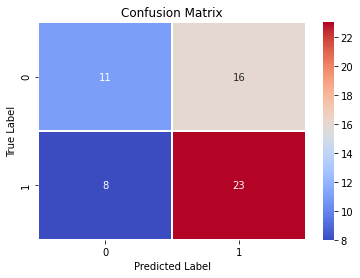


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.58      0.41      0.48        27
           1       0.59      0.74      0.66        31

    accuracy                           0.59        58
   macro avg       0.58      0.57      0.57        58
weighted avg       0.58      0.59      0.57        58



In [74]:
x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            25)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model.evaluate(x_test, y_test, verbose=verbose)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

# %%

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)

# %%

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


window size = 4 seconds
samples = 40*4 = 160

In [75]:
TIME_PERIODS = 160

In [76]:
x_train, y_train = create_segments_and_labels(df_train,TIME_PERIODS,25)
le = LabelEncoder()
LABELS= le.fit(y_train)
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)
verbose, epochs, batch_size = 0, 60, 32
# fit network
model = modelCNN(TIME_PERIODS,input_shape)
history4 = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)

[0, 1]
New y_train shape:  (180, 2)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 160, 3)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 151, 64)           1984      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 142, 64)           41024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 142, 64)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 47, 64)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 38, 128)           82048     
_________________________________________________________________
flatten_5 (Flatten

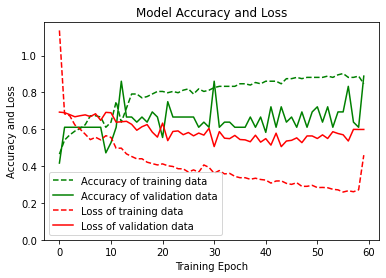

In [77]:
plt.figure(figsize=(6, 4))
plt.plot(history4.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history4.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history4.history['loss'], "r--", label="Loss of training data")
plt.plot(history4.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


Accuracy on test data: 0.69

Loss on test data: 2.81

--- Confusion matrix for test data ---



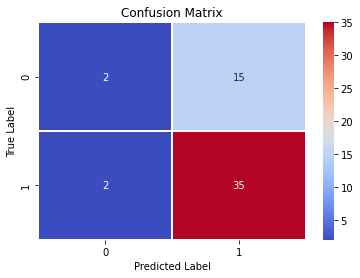


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.50      0.12      0.19        17
           1       0.70      0.95      0.80        37

    accuracy                           0.69        54
   macro avg       0.60      0.53      0.50        54
weighted avg       0.64      0.69      0.61        54



In [78]:
x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            25)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model.evaluate(x_test, y_test, verbose=verbose)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

# %%

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)

# %%

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

## Hyperparameter tuning

### Number of filters

In [80]:
n_params = [8, 16, 32, 64]

In [81]:
def modelCNNHP(TIME_PERIODS,input_shape,n_filters):
    model = Sequential()
    model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
    model.add(Conv1D(filters=n_filters, kernel_size=10, activation='relu',input_shape=(TIME_PERIODS,num_sensors)))
    model.add(Conv1D(filters=n_filters,kernel_size=10,activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=3))
    # model.add(Conv1D(160, 10, activation='relu'))
    # model.add(Conv1D(160, 10, activation='relu'))
    # model.add(GlobalAveragePooling1D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)
    _, accuracy = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=verbose)
    return accuracy

In [82]:
# summarize scores
from numpy import mean
from numpy import std

def summarize_results(scores, params):
    print(scores, params)
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    plt.boxplot(scores, labels=params)
    plt.show()
	# pyplot.savefig('exp_cnn_filters.png'
    

window size 5 seconds

In [83]:
TIME_PERIODS = 200
x_train, y_train = create_segments_and_labels(df_train,TIME_PERIODS,25)
le = LabelEncoder()
LABELS= le.fit(y_train)
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)
verbose, epochs, batch_size = 0, 60, 32
x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            25)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

# score = model.evaluate(x_test, y_test, verbose=verbose)

[0, 1]
New y_train shape:  (178, 2)


In [84]:
def run(params,repeats=5):
    all_scores = []
    for p in params:
        scores =[]
        for r in range(repeats):
            score = modelCNNHP(TIME_PERIODS,input_shape,p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    summarize_results(all_scores,params)
    

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 200, 3)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 191, 8)            248       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 182, 8)            648       
_________________________________________________________________
dropout_6 (Dropout)          (None, 182, 8)            0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 60, 8)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 480)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

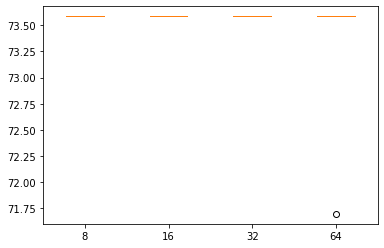

In [85]:
run(n_params)

size of kernel

In [86]:
n_params = [2, 3, 5,7,11]

In [87]:
def modelCNNHPK(TIME_PERIODS,input_shape,n_kernels):
    model = Sequential()
    model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
    model.add(Conv1D(filters=64, kernel_size=n_kernels, activation='relu',input_shape=(TIME_PERIODS,num_sensors)))
    model.add(Conv1D(filters=64,kernel_size=n_kernels,activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    # model.add(Conv1D(160, 10, activation='relu'))
    # model.add(Conv1D(160, 10, activation='relu'))
    # model.add(GlobalAveragePooling1D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    _, accuracy = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=verbose)
    return accuracy

In [88]:
def runK(params,repeats=5):
    all_scores = []
    for p in params:
        scores =[]
        for r in range(repeats):
            score = modelCNNHPK(TIME_PERIODS,input_shape,p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    summarize_results(all_scores,params)
    

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_26 (Reshape)         (None, 200, 3)            0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 199, 64)           448       
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 198, 64)           8256      
_________________________________________________________________
dropout_26 (Dropout)         (None, 198, 64)           0         
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 99, 64)            0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 6336)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)             

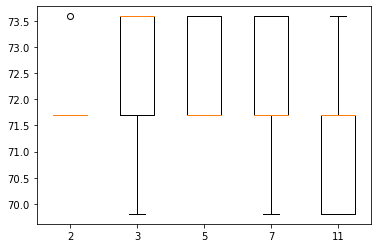

In [89]:
runK(n_params)